# 세상에 없는 얼굴 GAN, 오토인코더

## 3. 적대적 신경망 실행하기

### 실습: GAN 모델 만들기

C:\Users\user\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\user\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 28, 28, 1)           │         865,281 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 1)                   │         212,865 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,078,146 (4.11 MB)

 Trainable params: 852,609 (3.25 MB)

 Non-trainable params: 225,537 (881.00 KB)

C:\Users\user\AppData\Roaming\Python\Python312\site-packages\keras\src\backend\tensorflow\trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


epoch:0  d_loss:0.6919  g_loss:0.6950
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
epoch:100  d_loss:0.7522  g_loss:0.5738
epoch:200  d_loss:0.8225  g_loss:0.4942
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
epoch:300  d_loss:0.8872  g_loss:0.4327
epoch:400  d_loss:0.9380  g_loss:0.3897
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
epoch:500  d_loss:0.9779  g_loss:0.3581
epoch:600  d_loss:1.0103  g_loss:0.3339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
epoch:700  d_loss:1.0364  g_loss:0.3151
epoch:800  d_loss:1.0584  g_loss:0.2999
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
epoch:900  d_loss:1.0764  g_loss:0.2876
epoch:1000  d_loss:1.0914  g_loss:0.2776
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
epoch:1100  d_loss:1.1041  g_loss:0.2692
epoch:1200  d_loss:1.1148  g_loss:0.2621
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
epoch:1300  d_loss:1.1242  g_loss:0.2561
epoch:1400  d_loss:1.1323  g_loss:0.2508
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
epoch:1500  d_loss:1.1393  g_loss:0.2463
epoch:1600  d_loss:1.1454  g_loss:0.2424
1/1 ━━━━━━

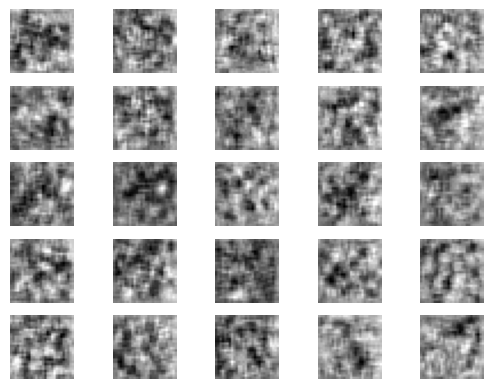

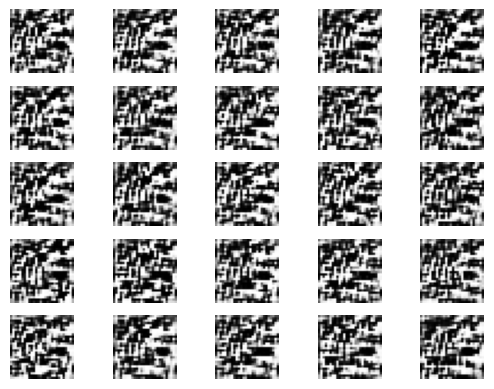

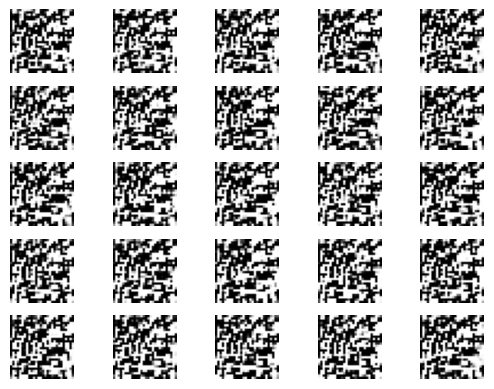

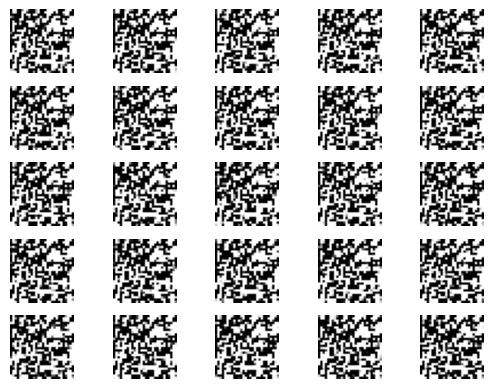

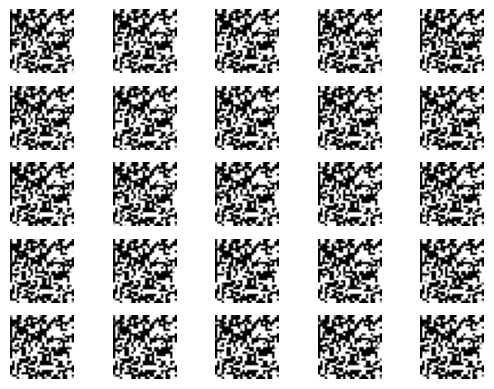

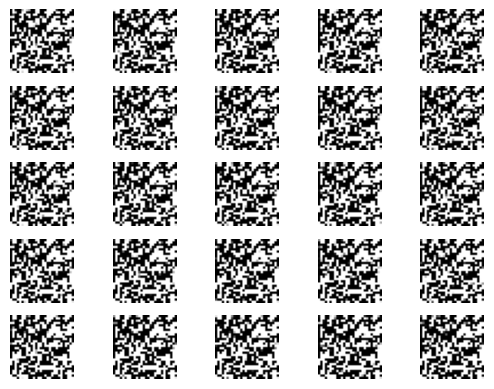

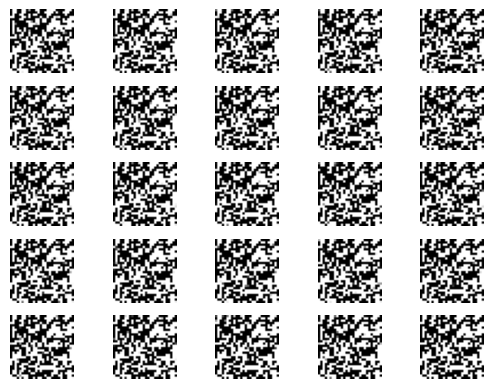

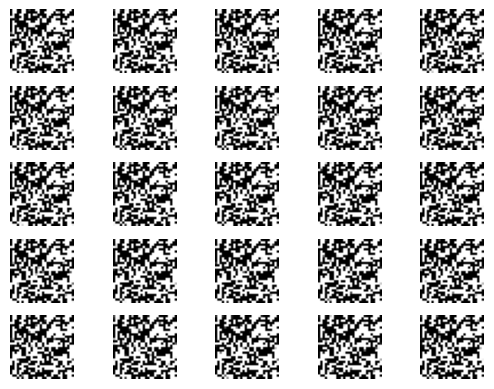

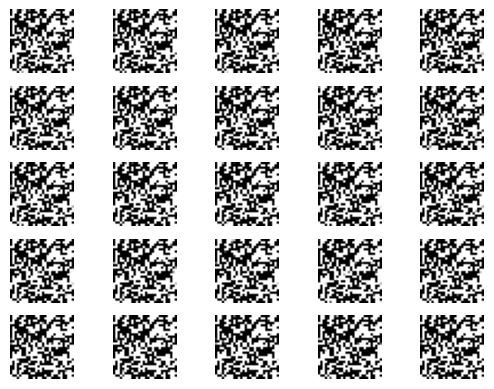

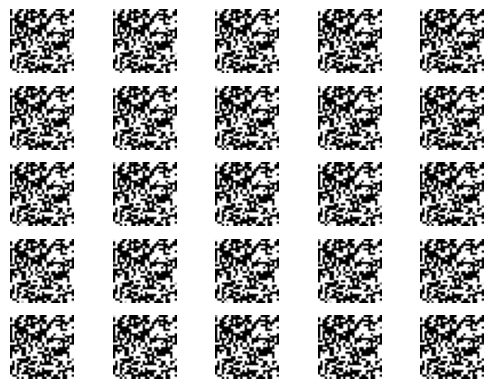

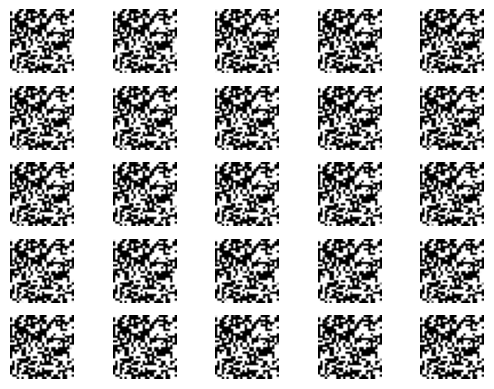

In [4]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import matplotlib.pyplot as plt

# 생성자 모델을 만듭니다.
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

# 판별자 모델을 만듭니다.
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

# 생성자와 판별자 모델을 연결시키는 gan 모델을 만듭니다.
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

# 신경망을 실행시키는 함수를 만듭니다.
def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터를 불러옵니다.

  (X_train, _), (_, _) = mnist.load_data()  # 앞서 불러온 적 있는 MNIST를 다시 이용합니다.
  #단, 테스트 과정은 필요 없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5) / 127.5  # 픽셀 값은 0에서 255 사이의 값입니다.
  #이전에 255로 나누어 줄때는 이를 0~1 사이의 값으로 바꾸었던 것인데,
  #여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다.
  # X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
          # 실제 데이터를 판별자에 입력하는 부분입니다.
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          imgs = X_train[idx]
          d_loss_real = discriminator.train_on_batch(imgs, true)

          # 가상 이미지를 판별자에 입력하는 부분입니다.
          noise = np.random.normal(0, 1, (batch_size, 100))
          gen_imgs = generator.predict(noise, verbose=0)
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

          # 판별자와 생성자의 오차를 계산합니다.
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          g_loss = gan.train_on_batch(noise, true)
          if i % 100 == 0:
              print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 이 부분은 중간 과정을 이미지로 저장해 주는 부분입니다. 이 장의 주요 내용과 관련이 없어
        # 소스 코드만 첨부합니다. 만들어진 이미지들은 gan_images 폴더에 저장됩니다.
          if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("./gan_mnist_%d.png" % i)

gan_train(2001, 32, 200)  # 2000번 반복되고, 배치 사이즈는 32,  200번마다 결과가 저장되게 하였습니다.


## 4. 이미지의 특징을 추출하는 오토인코더

### 실습: 오토인코더 실습하기

In [7]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape

import matplotlib.pyplot as plt
import numpy as np

# MNIST 데이터셋을 불러옵니다.

(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

# 생성자 모델을 만듭니다.
autoencoder = Sequential()

# 인코딩 부분입니다.
autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28,28,1), activation='relu'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu'))

# 디코딩 부분입니다.
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(16, kernel_size=3, activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))

# 전체 구조를 확인합니다.
autoencoder.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 4, 4, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 4, 4, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 8, 8, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 8, 8, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 14, 14, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 28, 28, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 28, 28, 1)           │             145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.3217 - val_loss: 0.1399
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1342 - val_loss: 0.1197
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1176 - val_loss: 0.1100
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1095 - val_loss: 0.1048
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1049 - val_loss: 0.1013
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1017 - val_loss: 0.0987
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0995 - val_loss: 0.0970
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0980 - val_loss: 0.0962
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0966 - val_loss: 0.0945
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0955 - val_loss: 0.0935
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0946 - val_loss: 0.0926
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step

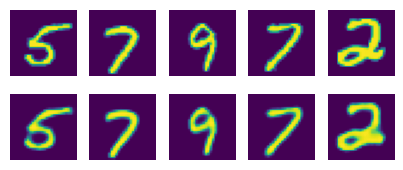

In [8]:
# 컴파일 및 학습을 하는 부분입니다.
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test))

# 학습된 결과를 출력하는 부분입니다.
random_test = np.random.randint(X_test.shape[0], size=5)  # 테스트할 이미지를 랜덤하게 불러옵니다.
ae_imgs = autoencoder.predict(X_test)                     # 앞서 만든 오토인코더 모델에 집어 넣습니다.

plt.figure(figsize=(7, 2))                         # 출력될 이미지의 크기를 정합니다.

for i, image_idx in enumerate(random_test):        # 랜덤하게 뽑은 이미지를 차례로 나열합니다.
   ax = plt.subplot(2, 7, i + 1)
   plt.imshow(X_test[image_idx].reshape(28, 28))   # 테스트할 이미지를 먼저 그대로 보여줍니다.
   ax.axis('off')
   ax = plt.subplot(2, 7, 7 + i +1)
   plt.imshow(ae_imgs[image_idx].reshape(28, 28))  # 오토인코딩 결과를 다음열에 출력합니다.
   ax.axis('off')
plt.show()